In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

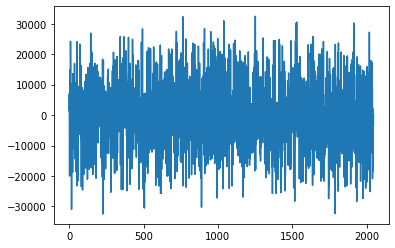

In [3]:
wave = np.fromfile('data/240611/calibrator_231001.bin' ,dtype=np.int16)
plt.plot(wave)
sampling_rate_cal=102.4e6
Ns = len(wave) # basic waveform length
Nx = 1 # number of repetitions we want to generate
Npt = Ns * Nx # total length


In [4]:
data1 = np.genfromtxt("data/240611/25mhz_m1200ms_240611_154509.csv", delimiter=',')[:,4]
sampling_rate_data = 250e6

In [5]:
wave_f = np.fft.rfft(wave)
freqs = np.fft.rfftfreq(Ns)
b_w = wave_f[181:-24:2]
f_og = freqs[181:-24:2]*sampling_rate_cal
print(f'frequency start: {f_og[0]}')
print(f'frequency end: {f_og[-1]}')
print(f'frequency steps: {(f_og[1] - f_og[0])}')

frequency start: 9050000.0
frequency end: 49950000.0
frequency steps: 100000.0


In [15]:
def get_peaks (signal, Nex=1, fbase=50e3, fstep=100e3, fmax=1e6, fdelta=30e3, sampling_rate=102.4e6):
    N = len(signal) 
    dt =  N*Nex/sampling_rate
    df = 1/dt
    window = np.hanning(N)
    signal_l = np.hstack( (signal*window, np.zeros(N*Nex-N)) )
    signal_f = np.fft.rfft(signal_l)
    freqs = []
    a_w = []
    back = []
    pows = []
    while fbase < fmax:
        ndx = int(fbase/df)
        delta_ndx = int(fdelta/df)
        slice = np.abs(signal_f[ndx-delta_ndx:ndx+delta_ndx])
        if len(slice) == 0: 
            break            # we reached the end            
        maxf_i = np.argmax(slice)+ndx-delta_ndx
        #print(ndx-delta_ndx,maxf_i, len(signal_f))
        back.append((maxf_i, signal_f[maxf_i]))
        freqs.append(maxf_i*df)
        a_w.append(signal_f[maxf_i])
        pows.append(signal_f[maxf_i]**2)
        fbase += fstep

    signal_f *= 0
    for a,b in back:
        signal_f[a] = b
    signal_l = np.fft.irfft(signal_f)[0:N]
    return np.array(freqs), np.array(a_w), np.array(pows), df, Nex*2*signal_l

In [7]:
def wrap_phase(x):
    return x-(np.round(x/2/np.pi))*2*np.pi

def find_dt(f_og, exp_iwt):
    dtmax = 2048/102.4e6
    print (f'dtmax: {dtmax}')
    angles = np.angle(exp_iwt)
    dts = np.linspace(-dtmax, dtmax,30000)
    def  pred(dt, ofs=0):
        return wrap_phase(ofs+f_og*dt)
    loss1 = np.array([((angles-pred(dt,0))**2).sum() for dt in dts])
    loss2 = np.array([((angles-pred(dt,np.pi))**2).sum() for dt in dts])
    loss = loss2 if loss2.min() < loss1.min() else loss1
    ofs = np.pi if loss2.min() < loss1.min() else 0
    bestdt = dts[np.argmin(loss)]
    print(np.argmin(loss))
    if ofs == np.pi: print(loss2[np.argmin(loss)])
    else: print(loss1[np.argmin(loss)])
    plt.plot(loss1,'r')
    plt.plot(loss2,'b')

    return bestdt, pred(bestdt,ofs),ofs


In [16]:
freqs, a_w, pows, df, sigb = get_peaks(data1, 20, fbase=9e6+50e3, fmax=50e6, sampling_rate=sampling_rate_data)


/cvmfs/sdcc.bnl.gov/jupyter/virtualenv/labenv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


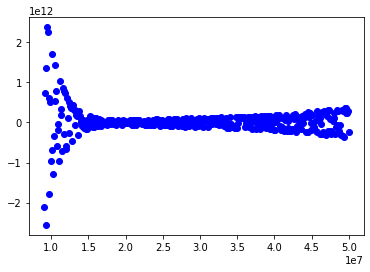

In [18]:
plt.plot(freqs, pows, 'bo')

In [9]:
bw_conj = np.conj(b_w)
amp_coefs = np.abs(a_w * bw_conj)

dtmax: 2e-05
22537
269.7152016007345
best dt: 1.0050335011167042e-05 
offset: 3.141592653589793


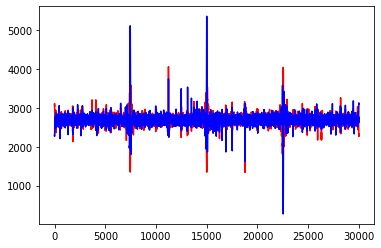

In [10]:
exp_iwt = (a_w * bw_conj) / amp_coefs
dtb, res,ofs = find_dt(f_og, exp_iwt)
print(f'best dt: {dtb} \noffset: {ofs}')


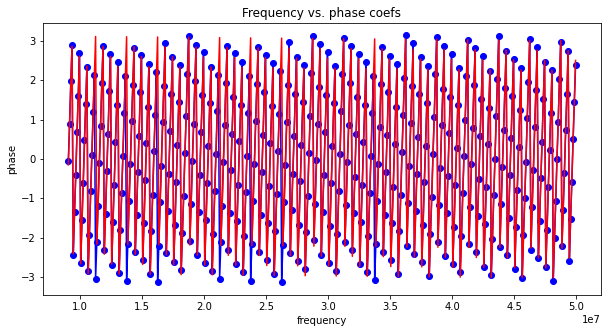

In [28]:
plt.figure(figsize=(10,5))
plt.plot(f_og, np.angle(exp_iwt),'bo-')
plt.plot(f_og, res,'r-')
plt.title('Frequency vs. phase coefs')
plt.xlabel('frequency')
plt.ylabel('phase')

plt.show()

In [20]:
resd = (res-np.angle(exp_iwt))**2 / (res**2)
idx = np.argmax(resd)
print(idx)
print(np.angle(exp_iwt)[idx])

369
-0.06648958098197394


7.2603796019408815
0.3524170171329329


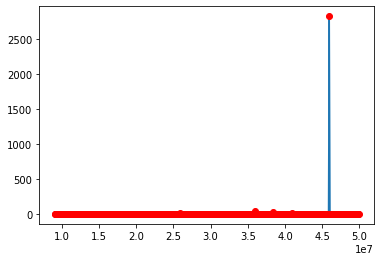

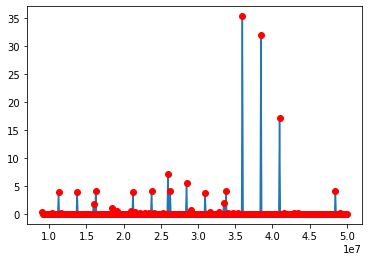

In [24]:
resd = (res-np.angle(exp_iwt))**2 / (res**2)

plt.figure()
plt.plot(f_og, resd)
plt.plot(f_og, resd, 'ro')
print(resd.mean())

resd[369] = 0
plt.figure()
plt.plot(f_og, resd)
plt.plot(f_og, resd, 'ro')
print(resd.mean())

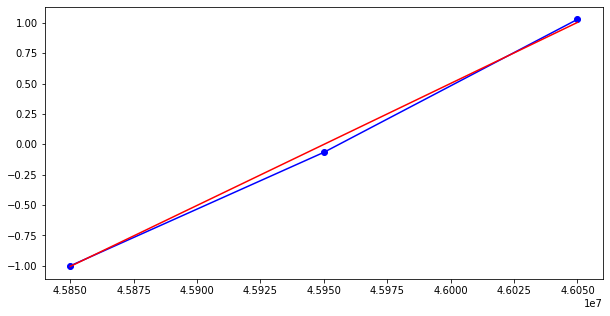

In [27]:
plt.figure(figsize=(10,5))
plt.plot(f_og[368:371], np.angle(exp_iwt)[368:371],'bo-')
plt.plot(f_og[368:371], res[368:371],'r-')